In [1]:
import keras
#from keras import Dense, Sequential, SGD, l2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l1_l2
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
#from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import train_test_split
import numpy as np
from numpy import loadtxt
from keras import backend as K

from scikeras.wrappers import KerasRegressor
import time
from sklearn.metrics import make_scorer

from matplotlib import pyplot as plt

2024-01-11 14:00:55.653415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 14:00:55.653448: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 14:00:55.654573: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 14:00:55.660458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:00:56.350894: W tensorflow/compiler/tf2

In [2]:
def read_tr(file_path, test_size=0.15, random_state=42):
    # load tr data
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)

    # Esclude la prima colonna e le ultime tre colonne (target)
    x = train[:, :-3]
    y = train[:, -3:]  # Le ultime tre colonne rappresentano i target

    # Suddivide il dataset in set di addestramento e test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    return x_train, y_train, x_test, y_test


def read_ts():
    file = "./cup/ds/ML-CUP23-TS.csv"
    test = loadtxt(file, delimiter=',', usecols=range(1, 11), dtype=np.float64)

    return test

def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

def create_model(layers=3, n_units=30, init_mode='glorot_normal', activation='tanh', lmb=0.0001, eta=0.002, alpha=0.01, batch_size=None):
    model = Sequential()
    
    # create hidden layers
    for i in range(layers):
        # dense is for units fully connected 
        model.add(Dense(n_units, kernel_initializer=init_mode, activation=activation, kernel_regularizer=l1_l2(lmb))) 

    # create output layer with 3 neurons for x, y, z
    model.add(Dense(3, activation='linear', kernel_initializer=init_mode))
    
    # use SGD optimizer
    optimizer = SGD(learning_rate=eta, momentum=alpha)
    
    model.compile(optimizer=optimizer, loss=euclidean_distance_loss, metrics=[euclidean_distance_loss])  # Aggiunto metrics=[euclidean_distance_loss]
    
    return model



    
# it retrieves the mean value of all the passed losses
def euclidean_distance_score(y_true, y_pred):
    return np.mean(euclidean_distance_loss(y_true, y_pred))


scorer = make_scorer(euclidean_distance_score, greater_is_better=False)

In [3]:

from sklearn.model_selection import ParameterGrid

def model_selection(x, y, epochs=1000):
    param_grid = {
        'n_units': [30],
        'init_mode': ['glorot_normal'],
        'activation': ['tanh'],
        'lmb': [0.0001,0.0005, 0.0008, 0.001, 0.005, 0.008, 0.01, 0.05, 0.08],
        'eta': [0.001, 0.002, 0.003],
        'alpha': [0.8, 0.9,0.95],
        #'batch_size': [32, 64,100, 128]  # Aggiungi diverse dimensioni del batch
        'batch_size': [100, 128]
    }

    param_combinations = list(ParameterGrid(param_grid))

    best_params = None
    best_loss = float('inf')  # Inizializza il miglior punteggio con un valore molto grande

    for params in param_combinations:
        # Crea e addestra il modello con gli iperparametri correnti
        model = create_model(layers=3, **params)
        history = model.fit(x, y, validation_split=0.3, epochs=epochs, batch_size=params['batch_size'], verbose=0)

        # Calcola la loss finale sul set di validazione
        val_loss = history.history['val_loss'][-1]

        # Calcola l'Euclidean Distance Loss
        val_score = euclidean_distance_score(y, model.predict(x))

        # Stampa euclidean_distance_loss e validation loss per ogni epoca
        print(f"\nParameters: {params}")
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs} - Euclidean Distance Loss: {history.history['euclidean_distance_loss'][epoch]:.4f} - Val Loss: {history.history['val_loss'][epoch]:.4f}")

        # Plot learning curve
        plot_learning_curve(history.history, epochs=epochs, start_epoch=1, **params)

        # Aggiorna il miglior punteggio e i relativi iperparametri se necessario
        if val_loss < best_loss:
            best_loss = val_loss
            best_params = params
            best_score = val_score

    print("\nBest Parameters:", best_params)
    print("Best Validation Loss:", best_loss)
    print("Best Euclidean Distance Score:", best_score)

    return best_params
    


In [4]:
'''
# grid search parallelized
from joblib import Parallel, delayed
from sklearn.model_selection import ParameterGrid

def train_and_evaluate_model(params, x, y, epochs=1000):
    model = create_model(layers=3, **params)
    history = model.fit(x, y, validation_split=0.3, epochs=epochs, batch_size=params['batch_size'], verbose=0)
    
    val_loss = history.history['val_loss'][-1]
    val_score = euclidean_distance_score(y, model.predict(x))
    
    print(f"\nParameters: {params}")
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs} - Euclidean Distance Loss: {history.history['euclidean_distance_loss'][epoch]:.4f} - Val Loss: {history.history['val_loss'][epoch]:.4f}")

    plot_learning_curve(history.history, epochs=epochs, start_epoch=1, **params)

    return params, val_loss, val_score, history.history

def model_selection(x, y, epochs=1000, n_jobs=-1):
    param_grid = {
        'n_units': [20, 30],
        'init_mode': ['glorot_normal'],
        'activation': ['tanh'],
        'lmb': [0.0001, 0.0005, 0.0008, 0.001, 0.005, 0.008, 0.01, 0.05, 0.08],
        'eta': [0.001, 0.002, 0.003],
        'alpha': [0.8, 0.9, 0.95],
        'batch_size': [100, 128]
    }

    param_combinations = list(ParameterGrid(param_grid))

    # Define the function to be parallelized
    def process_params(params):
        return train_and_evaluate_model(params, x, y, epochs)

    # Parallelize the grid search
    results = Parallel(n_jobs=n_jobs)(delayed(process_params)(params) for params in param_combinations)

    best_params, best_loss, best_score, best_history = min(results, key=lambda x: x[1])  # Assuming you're minimizing the loss

    print("\nBest Parameters:", best_params)
    print("Best Validation Loss:", best_loss)
    print("Best Euclidean Distance Score:", best_score)

    return best_params, best_history


'''


'\n# grid search parallelized\nfrom joblib import Parallel, delayed\nfrom sklearn.model_selection import ParameterGrid\n\ndef train_and_evaluate_model(params, x, y, epochs=1000):\n    model = create_model(layers=3, **params)\n    history = model.fit(x, y, validation_split=0.3, epochs=epochs, batch_size=params[\'batch_size\'], verbose=0)\n    \n    val_loss = history.history[\'val_loss\'][-1]\n    val_score = euclidean_distance_score(y, model.predict(x))\n    \n    print(f"\nParameters: {params}")\n    for epoch in range(epochs):\n        print(f"Epoch {epoch + 1}/{epochs} - Euclidean Distance Loss: {history.history[\'euclidean_distance_loss\'][epoch]:.4f} - Val Loss: {history.history[\'val_loss\'][epoch]:.4f}")\n\n    plot_learning_curve(history.history, epochs=epochs, start_epoch=1, **params)\n\n    return params, val_loss, val_score, history.history\n\ndef model_selection(x, y, epochs=1000, n_jobs=-1):\n    param_grid = {\n        \'n_units\': [20, 30],\n        \'init_mode\': [\'glo

In [5]:
def predict(model, x_ts, x_its, y_its):
    # predict on internal test set
    y_ipred = model.predict(x_its)
    _, iloss = model.evaluate(x_its, y_its, verbose=0)  # Utilizzo di evaluate invece di calcolare manualmente la loss

    # predict on blind test set
    y_pred = model.predict(x_ts)

    # return predicted target on blind test set,
    # and losses on internal test set
    return [y_pred[:, i] for i in range(y_pred.shape[1])], iloss
#y_pred sarà una matrice in cui ogni colonna rappresenta le previsioni per una delle tre variabili target. 
# La funzione restituirà quindi una lista di array, uno per ciascuna colonna.

In [6]:
def plot_learning_curve(history, start_epoch=1, **kwargs):
    lgd = ['Loss TR']
    plt.plot(range(start_epoch, kwargs['epochs']), history['loss'][start_epoch:])
    
    if "val_loss" in history:
        plt.plot(range(start_epoch, kwargs['epochs']), history['val_loss'][start_epoch:])
        lgd.append('Loss VL')

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f'Keras Learning Curve \n {kwargs}')
    plt.legend(lgd)

    # Check if predictions are available in the history
    if 'predictions' in history:
        predictions = history['predictions']
        
        # Plot predictions for each variable
        for i in range(predictions.shape[1]):
            plt.figure()
            plt.plot(range(start_epoch, kwargs['epochs']), predictions[:, i][start_epoch:])
            plt.xlabel("Epoch")
            plt.ylabel(f"Prediction Variable {i+1}")
            plt.title(f'Keras Learning Curve \n {kwargs} - Prediction Variable {i+1}')
    
    plt.show()


In [7]:
def keras_nn(ms=True):
    print("keras start")

    file_path_tr = "./cup/ds/ML-CUP23-TR.csv"
    # read training set
    x, y, x_its, y_its = read_tr(file_path_tr)

    # choose model selection or hand-given parameters
    if ms:
        params = model_selection(x, y)
    else:
        params = dict(eta=0.001, alpha=0.9, lmb=0.001, epochs=400, batch_size=80)
        #Parameters: {'activation': 'tanh', 'alpha': 0.9, 'batch_size': 128, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
        
        #Parameters: {'activation': 'tanh', 'alpha': 0.9, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
#Best Parameters: {'activation': 'tanh', 'alpha': 0.9, 'eta': 0.003, 'init_mode': 'glorot_uniform', 'lmb': 0.0001, 'n_units': 30}

    # create and fit the model
    model = create_model(eta=params['eta'], alpha=params['alpha'], lmb=params['lmb'])
    res = model.fit(x, y, validation_split=0.3, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1)

    tr_losses = res.history['loss']
    val_losses = res.history['val_loss']
    
    
  # Predict for the three variables
    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)

    print("TR Loss: ", tr_losses[-1])
    print("VL Loss: ", val_losses[-1])
    print("TS Loss: ", np.mean(ts_losses))

# Extract predictions for each variable
    y_pred_x, y_pred_y, y_pred_z = y_pred

    print("Predictions for X: ", y_pred_x)  
    print("Predictions for Y: ", y_pred_y)
    print("Predictions for Z: ", y_pred_z)

    print("keras end")

    plot_learning_curve(res.history, savefig=True, **params)
    

keras start


27/27 [==============================] - 0s 981us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.7693 - Val Loss: 43.5917
Epoch 2/1000 - Euclidean Distance Loss: 42.6528 - Val Loss: 43.4442
Epoch 3/1000 - Euclidean Distance Loss: 42.4996 - Val Loss: 43.2812
Epoch 4/1000 - Euclidean Distance Loss: 42.3370 - Val Loss: 43.1159
Epoch 5/1000 - Euclidean Distance Loss: 42.1739 - Val Loss: 42.9505
Epoch 6/1000 - Euclidean Distance Loss: 42.0114 - Val Loss: 42.7859
Epoch 7/1000 - Euclidean Distance Loss: 41.8496 - Val Loss: 42.6239
Epoch 8/1000 - Euclidean Distance Loss: 41.6904 - Val Loss: 42.4641
Epoch 9/1000 - Euclidean Distance Loss: 41.5331 - Val Loss: 42.3066
Epoch 10/1000 - Euclidean Distance Loss: 41.3786 - Val Loss: 42.1509
Epoch 11/1000 - Euclidean Distance Loss: 41.2260 - Val Loss: 41.9973
Epoch 12/1000 - Euclidean Distance Loss: 41.0744 - V

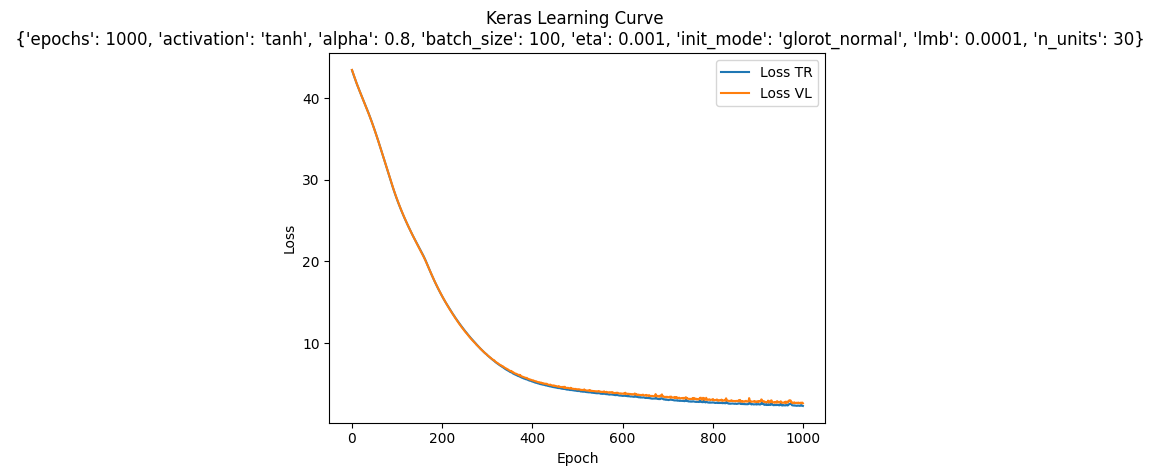

27/27 [==============================] - 0s 909us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.0005, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.4963 - Val Loss: 43.4787
Epoch 2/1000 - Euclidean Distance Loss: 42.3780 - Val Loss: 43.3303
Epoch 3/1000 - Euclidean Distance Loss: 42.2250 - Val Loss: 43.1641
Epoch 4/1000 - Euclidean Distance Loss: 42.0619 - Val Loss: 42.9952
Epoch 5/1000 - Euclidean Distance Loss: 41.8992 - Val Loss: 42.8273
Epoch 6/1000 - Euclidean Distance Loss: 41.7372 - Val Loss: 42.6638
Epoch 7/1000 - Euclidean Distance Loss: 41.5786 - Val Loss: 42.5057
Epoch 8/1000 - Euclidean Distance Loss: 41.4270 - Val Loss: 42.3486
Epoch 9/1000 - Euclidean Distance Loss: 41.2761 - Val Loss: 42.1973
Epoch 10/1000 - Euclidean Distance Loss: 41.1297 - Val Loss: 42.0510
Epoch 11/1000 - Euclidean Distance Loss: 40.9885 - Val Loss: 41.9076
Epoch 12/1000 - Euclidean Distance Loss: 40.8519 - V

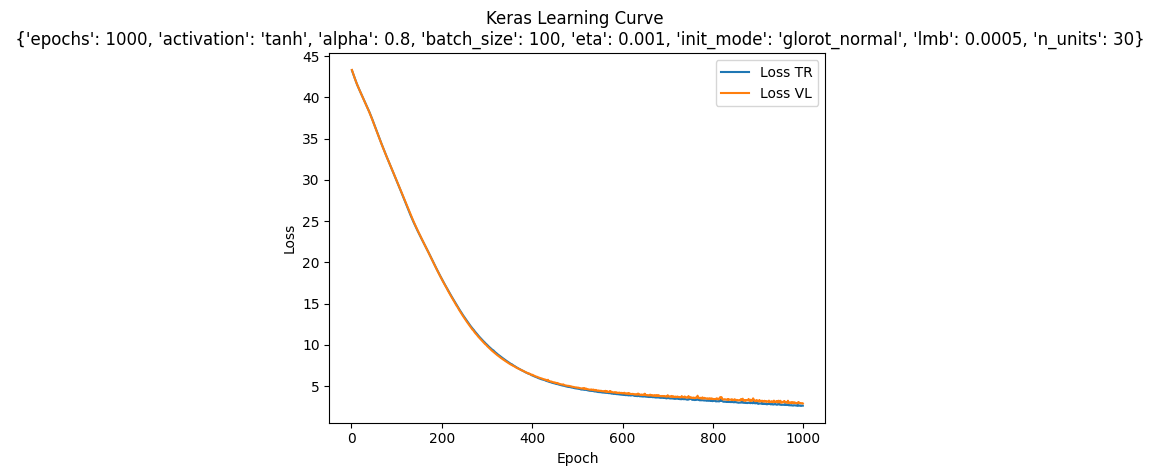

27/27 [==============================] - 0s 740us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.0008, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.8097 - Val Loss: 43.8683
Epoch 2/1000 - Euclidean Distance Loss: 42.6858 - Val Loss: 43.7137
Epoch 3/1000 - Euclidean Distance Loss: 42.5218 - Val Loss: 43.5436
Epoch 4/1000 - Euclidean Distance Loss: 42.3499 - Val Loss: 43.3694
Epoch 5/1000 - Euclidean Distance Loss: 42.1748 - Val Loss: 43.1963
Epoch 6/1000 - Euclidean Distance Loss: 42.0011 - Val Loss: 43.0244
Epoch 7/1000 - Euclidean Distance Loss: 41.8279 - Val Loss: 42.8548
Epoch 8/1000 - Euclidean Distance Loss: 41.6577 - Val Loss: 42.6860
Epoch 9/1000 - Euclidean Distance Loss: 41.4874 - Val Loss: 42.5205
Epoch 10/1000 - Euclidean Distance Loss: 41.3208 - Val Loss: 42.3569
Epoch 11/1000 - Euclidean Distance Loss: 41.1557 - Val Loss: 42.1951
Epoch 12/1000 - Euclidean Distance Loss: 40.9925 - V

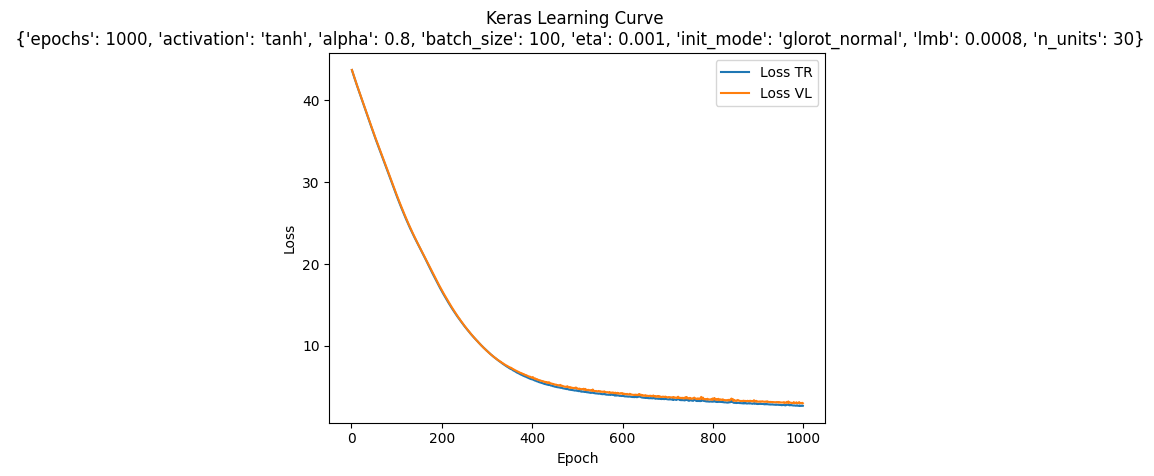

27/27 [==============================] - 0s 817us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.7157 - Val Loss: 43.8324
Epoch 2/1000 - Euclidean Distance Loss: 42.5981 - Val Loss: 43.6844
Epoch 3/1000 - Euclidean Distance Loss: 42.4453 - Val Loss: 43.5221
Epoch 4/1000 - Euclidean Distance Loss: 42.2839 - Val Loss: 43.3588
Epoch 5/1000 - Euclidean Distance Loss: 42.1243 - Val Loss: 43.1964
Epoch 6/1000 - Euclidean Distance Loss: 41.9654 - Val Loss: 43.0366
Epoch 7/1000 - Euclidean Distance Loss: 41.8089 - Val Loss: 42.8795
Epoch 8/1000 - Euclidean Distance Loss: 41.6548 - Val Loss: 42.7245
Epoch 9/1000 - Euclidean Distance Loss: 41.5022 - Val Loss: 42.5711
Epoch 10/1000 - Euclidean Distance Loss: 41.3516 - Val Loss: 42.4192
Epoch 11/1000 - Euclidean Distance Loss: 41.2024 - Val Loss: 42.2682
Epoch 12/1000 - Euclidean Distance Loss: 41.0532 - Va

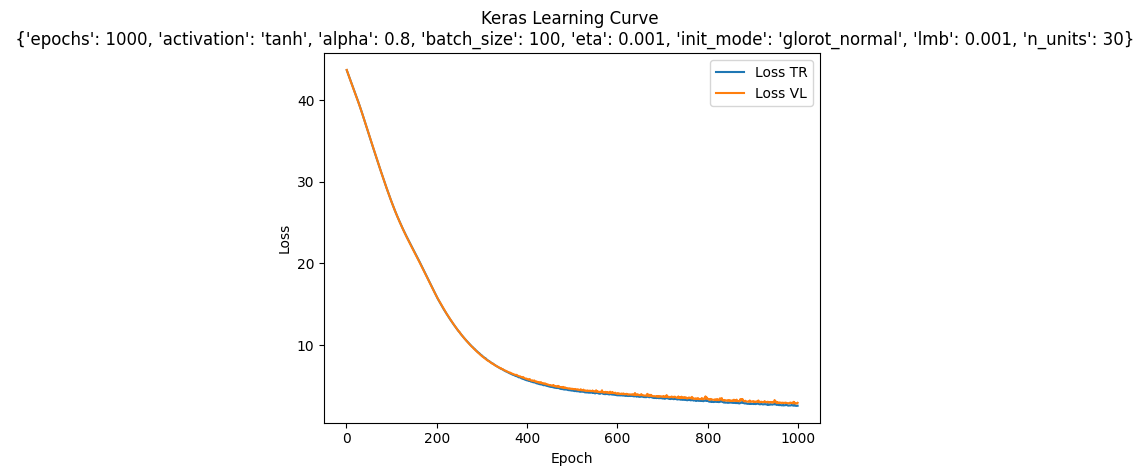

27/27 [==============================] - 0s 773us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.005, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.8816 - Val Loss: 45.3078
Epoch 2/1000 - Euclidean Distance Loss: 42.7719 - Val Loss: 45.1638
Epoch 3/1000 - Euclidean Distance Loss: 42.6273 - Val Loss: 45.0070
Epoch 4/1000 - Euclidean Distance Loss: 42.4767 - Val Loss: 44.8492
Epoch 5/1000 - Euclidean Distance Loss: 42.3273 - Val Loss: 44.6944
Epoch 6/1000 - Euclidean Distance Loss: 42.1808 - Val Loss: 44.5449
Epoch 7/1000 - Euclidean Distance Loss: 42.0391 - Val Loss: 44.4004
Epoch 8/1000 - Euclidean Distance Loss: 41.9025 - Val Loss: 44.2611
Epoch 9/1000 - Euclidean Distance Loss: 41.7697 - Val Loss: 44.1273
Epoch 10/1000 - Euclidean Distance Loss: 41.6422 - Val Loss: 43.9973
Epoch 11/1000 - Euclidean Distance Loss: 41.5184 - Val Loss: 43.8708
Epoch 12/1000 - Euclidean Distance Loss: 41.3969 - Va

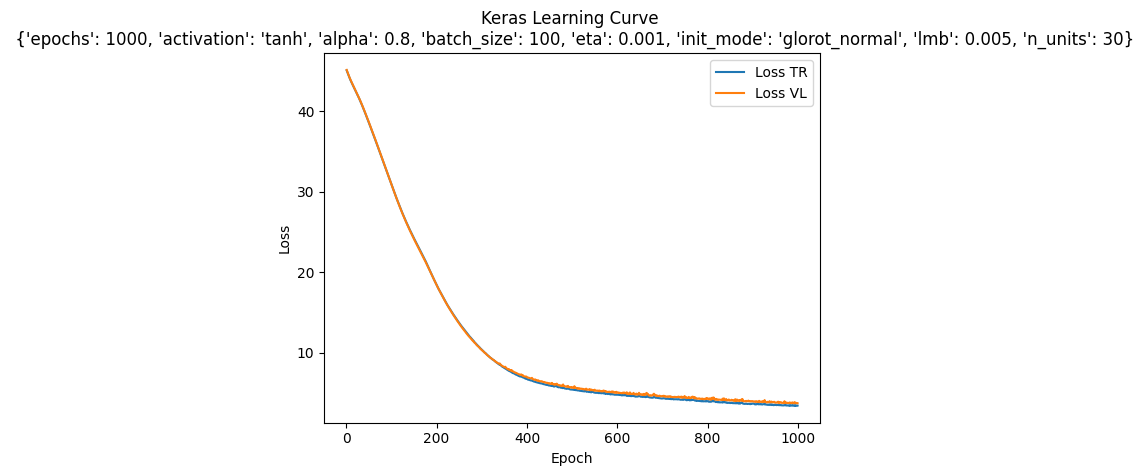

27/27 [==============================] - 0s 751us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.008, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.5800 - Val Loss: 45.9715
Epoch 2/1000 - Euclidean Distance Loss: 42.4927 - Val Loss: 45.8537
Epoch 3/1000 - Euclidean Distance Loss: 42.3775 - Val Loss: 45.7249
Epoch 4/1000 - Euclidean Distance Loss: 42.2567 - Val Loss: 45.5935
Epoch 5/1000 - Euclidean Distance Loss: 42.1347 - Val Loss: 45.4626
Epoch 6/1000 - Euclidean Distance Loss: 42.0136 - Val Loss: 45.3330
Epoch 7/1000 - Euclidean Distance Loss: 41.8928 - Val Loss: 45.2051
Epoch 8/1000 - Euclidean Distance Loss: 41.7737 - Val Loss: 45.0779
Epoch 9/1000 - Euclidean Distance Loss: 41.6550 - Val Loss: 44.9520
Epoch 10/1000 - Euclidean Distance Loss: 41.5372 - Val Loss: 44.8267
Epoch 11/1000 - Euclidean Distance Loss: 41.4195 - Val Loss: 44.7023
Epoch 12/1000 - Euclidean Distance Loss: 41.3016 - Va

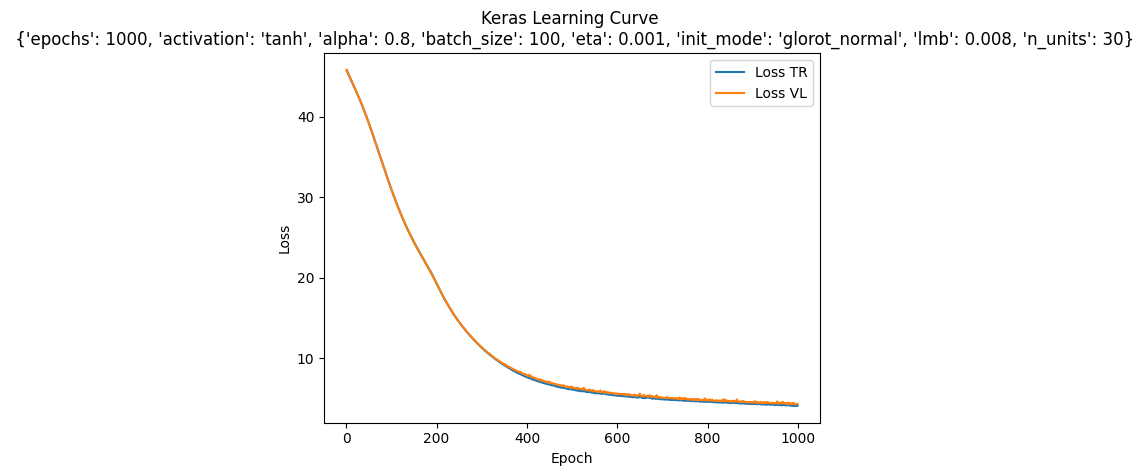

27/27 [==============================] - 0s 790us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.01, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 43.0298 - Val Loss: 47.2082
Epoch 2/1000 - Euclidean Distance Loss: 42.9165 - Val Loss: 47.0533
Epoch 3/1000 - Euclidean Distance Loss: 42.7676 - Val Loss: 46.8833
Epoch 4/1000 - Euclidean Distance Loss: 42.6109 - Val Loss: 46.7107
Epoch 5/1000 - Euclidean Distance Loss: 42.4521 - Val Loss: 46.5401
Epoch 6/1000 - Euclidean Distance Loss: 42.2962 - Val Loss: 46.3712
Epoch 7/1000 - Euclidean Distance Loss: 42.1420 - Val Loss: 46.2040
Epoch 8/1000 - Euclidean Distance Loss: 41.9892 - Val Loss: 46.0407
Epoch 9/1000 - Euclidean Distance Loss: 41.8391 - Val Loss: 45.8804
Epoch 10/1000 - Euclidean Distance Loss: 41.6924 - Val Loss: 45.7220
Epoch 11/1000 - Euclidean Distance Loss: 41.5468 - Val Loss: 45.5670
Epoch 12/1000 - Euclidean Distance Loss: 41.4037 - Val

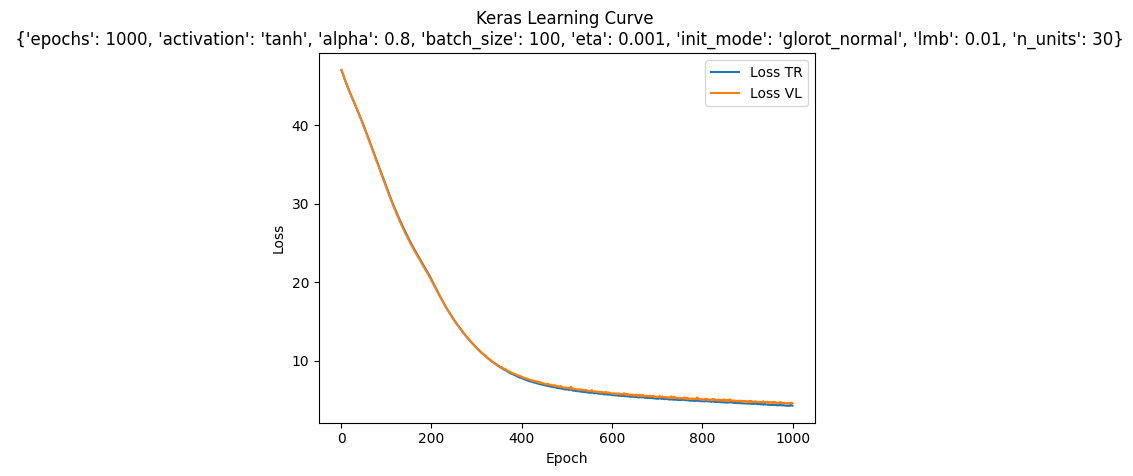

27/27 [==============================] - 0s 766us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.05, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.6546 - Val Loss: 59.6798
Epoch 2/1000 - Euclidean Distance Loss: 42.5644 - Val Loss: 59.4146
Epoch 3/1000 - Euclidean Distance Loss: 42.4469 - Val Loss: 59.1252
Epoch 4/1000 - Euclidean Distance Loss: 42.3244 - Val Loss: 58.8332
Epoch 5/1000 - Euclidean Distance Loss: 42.2035 - Val Loss: 58.5435
Epoch 6/1000 - Euclidean Distance Loss: 42.0838 - Val Loss: 58.2582
Epoch 7/1000 - Euclidean Distance Loss: 41.9665 - Val Loss: 57.9781
Epoch 8/1000 - Euclidean Distance Loss: 41.8520 - Val Loss: 57.7024
Epoch 9/1000 - Euclidean Distance Loss: 41.7395 - Val Loss: 57.4317
Epoch 10/1000 - Euclidean Distance Loss: 41.6290 - Val Loss: 57.1651
Epoch 11/1000 - Euclidean Distance Loss: 41.5203 - Val Loss: 56.9017
Epoch 12/1000 - Euclidean Distance Loss: 41.4127 - Val

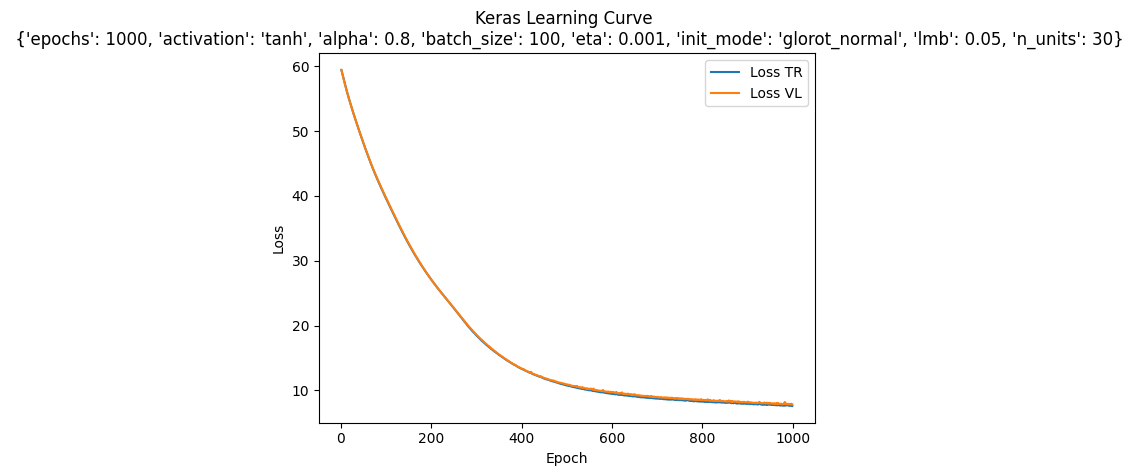

27/27 [==============================] - 0s 708us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.001, 'init_mode': 'glorot_normal', 'lmb': 0.08, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.8014 - Val Loss: 68.8818
Epoch 2/1000 - Euclidean Distance Loss: 42.6928 - Val Loss: 68.3738
Epoch 3/1000 - Euclidean Distance Loss: 42.5565 - Val Loss: 67.8255
Epoch 4/1000 - Euclidean Distance Loss: 42.4202 - Val Loss: 67.2783
Epoch 5/1000 - Euclidean Distance Loss: 42.2894 - Val Loss: 66.7467
Epoch 6/1000 - Euclidean Distance Loss: 42.1693 - Val Loss: 66.2271
Epoch 7/1000 - Euclidean Distance Loss: 42.0550 - Val Loss: 65.7210
Epoch 8/1000 - Euclidean Distance Loss: 41.9483 - Val Loss: 65.2300
Epoch 9/1000 - Euclidean Distance Loss: 41.8485 - Val Loss: 64.7517
Epoch 10/1000 - Euclidean Distance Loss: 41.7548 - Val Loss: 64.2827
Epoch 11/1000 - Euclidean Distance Loss: 41.6655 - Val Loss: 63.8243
Epoch 12/1000 - Euclidean Distance Loss: 41.5795 - Val

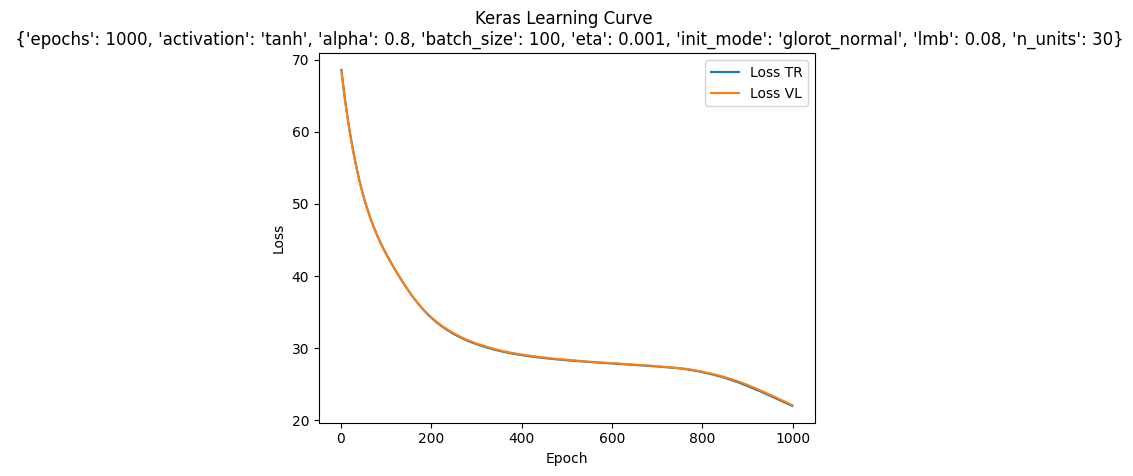

27/27 [==============================] - 0s 756us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.5610 - Val Loss: 43.4130
Epoch 2/1000 - Euclidean Distance Loss: 42.3589 - Val Loss: 43.1604
Epoch 3/1000 - Euclidean Distance Loss: 42.0919 - Val Loss: 42.8795
Epoch 4/1000 - Euclidean Distance Loss: 41.8073 - Val Loss: 42.5917
Epoch 5/1000 - Euclidean Distance Loss: 41.5180 - Val Loss: 42.3029
Epoch 6/1000 - Euclidean Distance Loss: 41.2272 - Val Loss: 42.0145
Epoch 7/1000 - Euclidean Distance Loss: 40.9356 - Val Loss: 41.7257
Epoch 8/1000 - Euclidean Distance Loss: 40.6431 - Val Loss: 41.4360
Epoch 9/1000 - Euclidean Distance Loss: 40.3495 - Val Loss: 41.1430
Epoch 10/1000 - Euclidean Distance Loss: 40.0488 - Val Loss: 40.8509
Epoch 11/1000 - Euclidean Distance Loss: 39.7504 - Val Loss: 40.5522
Epoch 12/1000 - Euclidean Distance Loss: 39.4455 - V

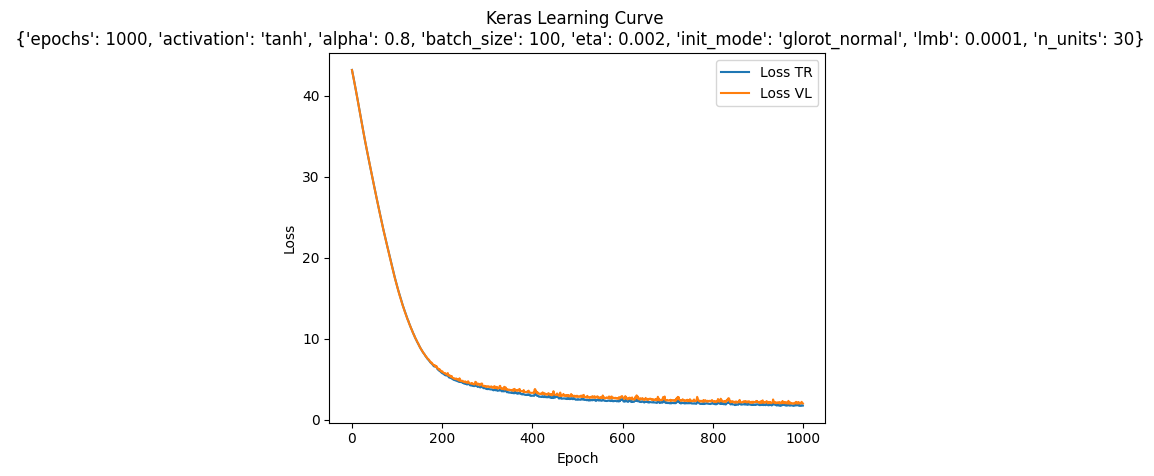

27/27 [==============================] - 0s 744us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.0005, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.7477 - Val Loss: 43.6430
Epoch 2/1000 - Euclidean Distance Loss: 42.4850 - Val Loss: 43.3159
Epoch 3/1000 - Euclidean Distance Loss: 42.1461 - Val Loss: 42.9631
Epoch 4/1000 - Euclidean Distance Loss: 41.7989 - Val Loss: 42.6201
Epoch 5/1000 - Euclidean Distance Loss: 41.4628 - Val Loss: 42.2972
Epoch 6/1000 - Euclidean Distance Loss: 41.1487 - Val Loss: 41.9892
Epoch 7/1000 - Euclidean Distance Loss: 40.8452 - Val Loss: 41.6970
Epoch 8/1000 - Euclidean Distance Loss: 40.5576 - Val Loss: 41.4123
Epoch 9/1000 - Euclidean Distance Loss: 40.2743 - Val Loss: 41.1351
Epoch 10/1000 - Euclidean Distance Loss: 39.9972 - Val Loss: 40.8611
Epoch 11/1000 - Euclidean Distance Loss: 39.7233 - Val Loss: 40.5877
Epoch 12/1000 - Euclidean Distance Loss: 39.4486 - V

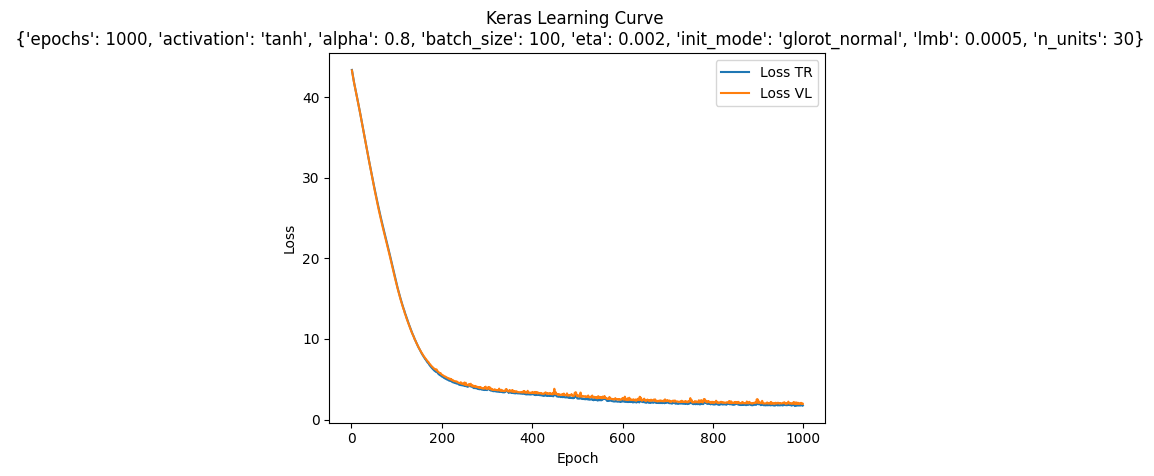

27/27 [==============================] - 0s 762us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.0008, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.7491 - Val Loss: 43.8315
Epoch 2/1000 - Euclidean Distance Loss: 42.5484 - Val Loss: 43.5800
Epoch 3/1000 - Euclidean Distance Loss: 42.2878 - Val Loss: 43.3107
Epoch 4/1000 - Euclidean Distance Loss: 42.0236 - Val Loss: 43.0418
Epoch 5/1000 - Euclidean Distance Loss: 41.7590 - Val Loss: 42.7850
Epoch 6/1000 - Euclidean Distance Loss: 41.5067 - Val Loss: 42.5347
Epoch 7/1000 - Euclidean Distance Loss: 41.2604 - Val Loss: 42.2900
Epoch 8/1000 - Euclidean Distance Loss: 41.0194 - Val Loss: 42.0485
Epoch 9/1000 - Euclidean Distance Loss: 40.7799 - Val Loss: 41.8097
Epoch 10/1000 - Euclidean Distance Loss: 40.5429 - Val Loss: 41.5700
Epoch 11/1000 - Euclidean Distance Loss: 40.3063 - Val Loss: 41.3285
Epoch 12/1000 - Euclidean Distance Loss: 40.0653 - V

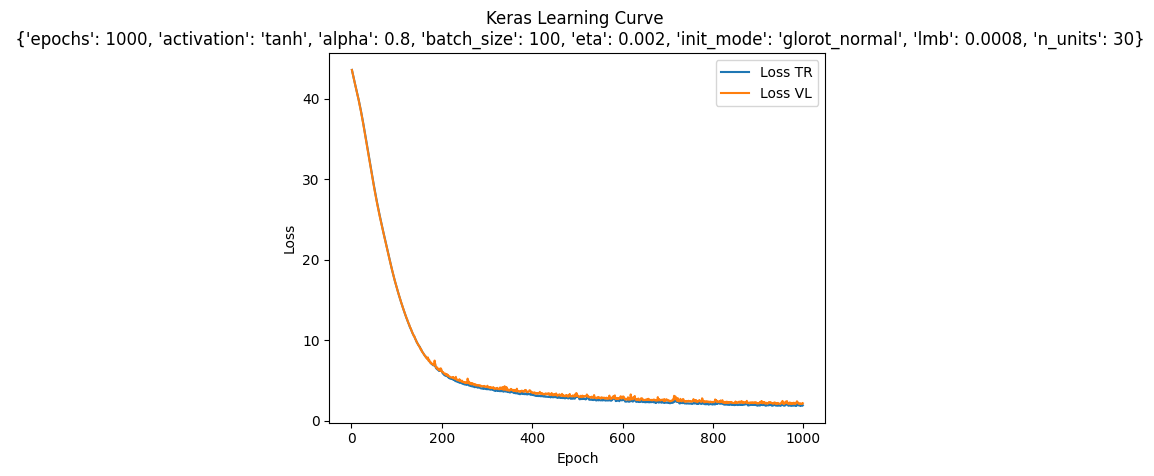

27/27 [==============================] - 0s 830us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.3249 - Val Loss: 43.4172
Epoch 2/1000 - Euclidean Distance Loss: 42.0692 - Val Loss: 43.0996
Epoch 3/1000 - Euclidean Distance Loss: 41.7430 - Val Loss: 42.7645
Epoch 4/1000 - Euclidean Distance Loss: 41.4141 - Val Loss: 42.4345
Epoch 5/1000 - Euclidean Distance Loss: 41.0940 - Val Loss: 42.1136
Epoch 6/1000 - Euclidean Distance Loss: 40.7811 - Val Loss: 41.8033
Epoch 7/1000 - Euclidean Distance Loss: 40.4761 - Val Loss: 41.5008
Epoch 8/1000 - Euclidean Distance Loss: 40.1800 - Val Loss: 41.2017
Epoch 9/1000 - Euclidean Distance Loss: 39.8840 - Val Loss: 40.9089
Epoch 10/1000 - Euclidean Distance Loss: 39.5947 - Val Loss: 40.6168
Epoch 11/1000 - Euclidean Distance Loss: 39.3047 - Val Loss: 40.3277
Epoch 12/1000 - Euclidean Distance Loss: 39.0164 - Va

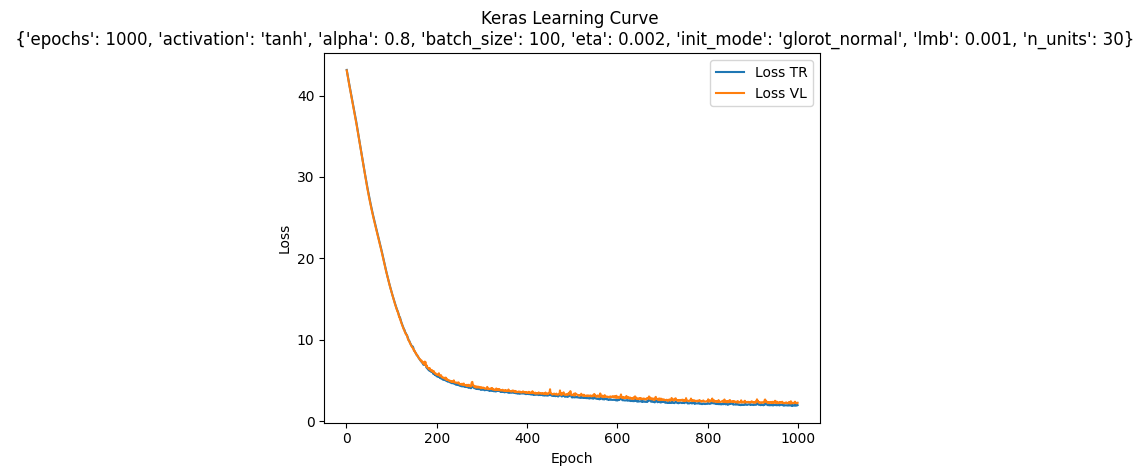

27/27 [==============================] - 0s 793us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.005, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 42.8443 - Val Loss: 45.3145
Epoch 2/1000 - Euclidean Distance Loss: 42.6105 - Val Loss: 45.0081
Epoch 3/1000 - Euclidean Distance Loss: 42.3129 - Val Loss: 44.6861
Epoch 4/1000 - Euclidean Distance Loss: 42.0143 - Val Loss: 44.3733
Epoch 5/1000 - Euclidean Distance Loss: 41.7248 - Val Loss: 44.0782
Epoch 6/1000 - Euclidean Distance Loss: 41.4518 - Val Loss: 43.7951
Epoch 7/1000 - Euclidean Distance Loss: 41.1885 - Val Loss: 43.5237
Epoch 8/1000 - Euclidean Distance Loss: 40.9357 - Val Loss: 43.2586
Epoch 9/1000 - Euclidean Distance Loss: 40.6871 - Val Loss: 43.0001
Epoch 10/1000 - Euclidean Distance Loss: 40.4441 - Val Loss: 42.7448
Epoch 11/1000 - Euclidean Distance Loss: 40.2013 - Val Loss: 42.4929
Epoch 12/1000 - Euclidean Distance Loss: 39.9603 - Va

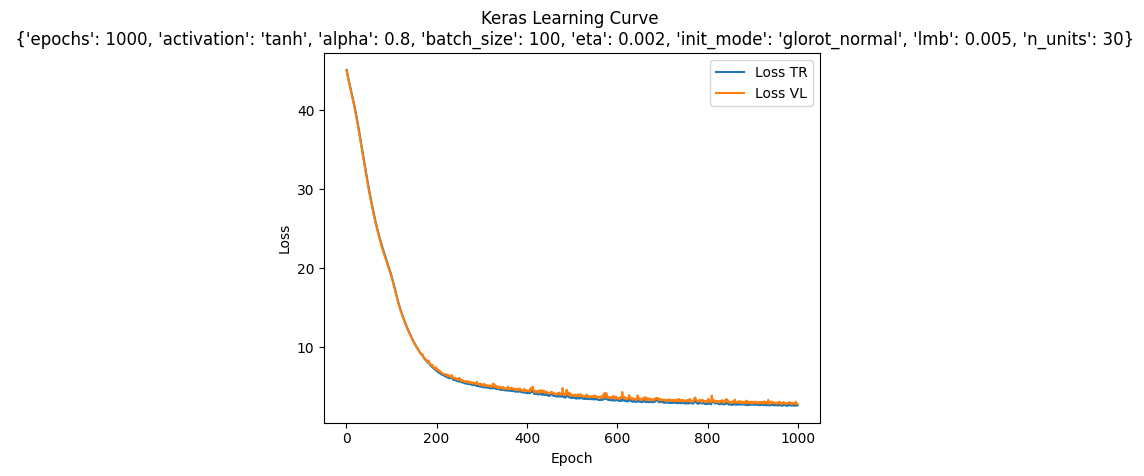

27/27 [==============================] - 0s 758us/step

Parameters: {'activation': 'tanh', 'alpha': 0.8, 'batch_size': 100, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.008, 'n_units': 30}
Epoch 1/1000 - Euclidean Distance Loss: 43.2569 - Val Loss: 46.5319
Epoch 2/1000 - Euclidean Distance Loss: 43.0384 - Val Loss: 46.2432
Epoch 3/1000 - Euclidean Distance Loss: 42.7551 - Val Loss: 45.9307
Epoch 4/1000 - Euclidean Distance Loss: 42.4596 - Val Loss: 45.6195
Epoch 5/1000 - Euclidean Distance Loss: 42.1675 - Val Loss: 45.3141
Epoch 6/1000 - Euclidean Distance Loss: 41.8795 - Val Loss: 45.0151
Epoch 7/1000 - Euclidean Distance Loss: 41.5962 - Val Loss: 44.7207
Epoch 8/1000 - Euclidean Distance Loss: 41.3148 - Val Loss: 44.4294
Epoch 9/1000 - Euclidean Distance Loss: 41.0346 - Val Loss: 44.1375
Epoch 10/1000 - Euclidean Distance Loss: 40.7519 - Val Loss: 43.8453
Epoch 11/1000 - Euclidean Distance Loss: 40.4663 - Val Loss: 43.5504
Epoch 12/1000 - Euclidean Distance Loss: 40.1763 - Va

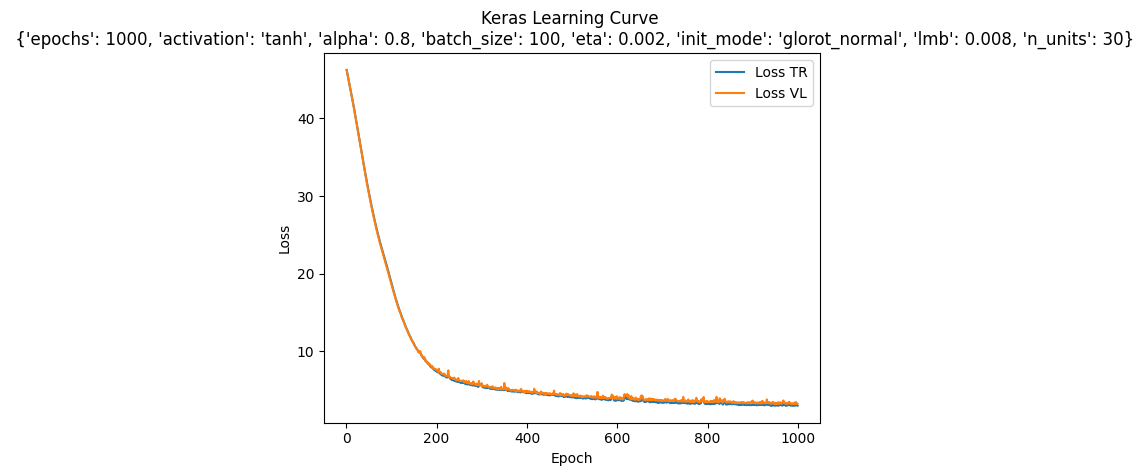

KeyboardInterrupt: 

In [8]:
keras_nn()

'''
grid search params:     param_grid = {
        'n_units': [30],
        'init_mode': ['glorot_normal', 'glorot_uniform'],
        'activation': ['tanh', 'sigmoid'],
        'lmb': [0.0001, 0.001, 0.01],
        'eta': [0.001, 0.002, 0.003],
        'alpha': [0.5, 0.6, 0.7, 0.8, 0.9]
    }
'''

# Parameters: {'activation': 'tanh', 'alpha': 0.5, 'eta': 0.003, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 2.6443 - Val Loss: 3.0714

#Parameters: {'activation': 'tanh', 'alpha': 0.5, 'eta': 0.003, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 2.5622 - Val Loss: 2.8697

#Parameters: {'activation': 'tanh', 'alpha': 0.6, 'eta': 0.003, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 2.1453 - Val Loss: 2.4879

#Parameters: {'activation': 'tanh', 'alpha': 0.7, 'eta': 0.003, 'init_mode': 'glorot_normal', 'lmb': 0.01, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 1.8586 - Val Loss: 2.8972

#Parameters: {'activation': 'tanh', 'alpha': 0.7, 'eta': 0.003, 'init_mode': 'glorot_normal', 'lmb': 0.001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 1.5949 - Val Loss: 1.9892

#Parameters: {'activation': 'tanh', 'alpha': 0.7, 'eta': 0.003, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 1.5246 - Val Loss: 1.990



#Epoch 300/300 - Euclidean Distance Loss: 1.3468 - Val Loss: 1.7966
#Parameters: {'activation': 'tanh', 'alpha': 0.7, 'eta': 0.003, 'init_mode': 'glorot_uniform', 'lmb': 0.0001, 'n_units': 30}

#Parameters: {'activation': 'tanh', 'alpha': 0.8, 'eta': 0.003, 'init_mode': 'glorot_uniform', 'lmb': 0.001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 1.1074 - Val Loss: 1.5142


#Parameters: {'activation': 'tanh', 'alpha': 0.8, 'eta': 0.003, 'init_mode': 'glorot_uniform', 'lmb': 0.0001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 1.0987 - Val Loss: 1.5069


#Parameters: {'activation': 'tanh', 'alpha': 0.9, 'eta': 0.001, 'init_mode': 'glorot_uniform', 'lmb': 0.001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 1.3518 - Val Loss: 1.8703

#Parameters: {'activation': 'tanh', 'alpha': 0.9, 'eta': 0.002, 'init_mode': 'glorot_normal', 'lmb': 0.0001, 'n_units': 30}
#Epoch 300/300 - Euclidean Distance Loss: 0.8125 - Val Loss: 1.2052

#with sigmod the model sucks: go for tanh